In [1]:
import sys
sys.path.append("../")

import pandas as pd
import os
import numpy as np

from library import regulations
from library import analysis
from library import tables
import statsmodels.formula.api as smf


In [2]:
data_path = '/Users/kylieleblancKylie/domino/dofis/data/'
table_path = '/Users/kylieleblancKylie/domino/dofis/results/descriptive/'
data = pd.read_csv(os.path.join(data_path, 'clean', 'master_data_district.csv'),
                  sep=",")
data.sample(5)

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,year,district,distname,distischarter,rating_academic,rating_financial,type,type_description,cntyname,...,district_status,type_urban,type_suburban,type_town,type_rural,eligible,teachers_nodegree,teachers_badegree,teachers_msdegree,teachers_phddegree
3919,3919,2015,50901,EVANT ISD,N,M,Pass,E,INDEPENDENT TOWN,CORYELL,...,doi,0,0,1,0,1,0.000000,0.954545,0.045455,0.0
6813,6813,2017,133905,DIVIDE ISD,N,M,Pass,H,RURAL,KERR,...,tps,0,0,0,1,1,0.000000,0.833333,0.166667,0.0
2519,2519,2014,15816,ACADEMY OF CAREERS AND TECHNOLOGIE,Y,I,NaN,I,CHARTER SCHOOL DISTRICTS,BEXAR,...,charter,0,0,0,0,0,0.100008,0.800004,0.099988,0.0
6760,6760,2017,121906,EVADALE ISD,N,M,Pass,H,RURAL,JASPER,...,doi,0,0,0,1,1,0.000000,0.953917,0.046083,0.0
1549,1549,2013,62901,CUERO ISD,N,M,NaN,G,NON-METROPOLITAN STABLE,DEWITT,...,doi,0,0,1,0,1,0.000000,0.862069,0.139208,0.0


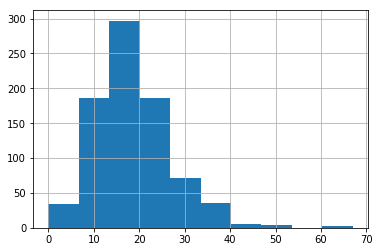

In [13]:
data = data[data.year == 2016]
data = data[data.doi == True]
data.sample(5)
data.teachers_turnover_ratio.hist()

# Teacher Turnover

In [14]:
bins = [0,10, 20, 30, 40, 100]
labels = ['<10%', '10%-20%', '20%-30%', '30%-40%', '>40%']
data['bins']  = pd.cut(data['teachers_turnover_ratio'], bins, labels = labels)
data[['bins', 'teachers_turnover_ratio']].sample(5)

,bins,teachers_turnover_ratio
6075,10%-20%,11.3
6093,10%-20%,17.1
5551,10%-20%,18.5
5356,20%-30%,20.8
5864,10%-20%,17.0


In [15]:
data['bin10'] = np.where(data.bins == '<10%', 1, 0)
data['bin20'] = np.where(data.bins == '10%-20%', 1, 0)
data['bin30'] = np.where(data.bins == '20%-30%', 1, 0)
data['bin40'] = np.where(data.bins == '30%-40%', 1, 0)
data['bin100'] = np.where(data.bins == '>40%', 1, 0)

In [16]:
list(data.bins.value_counts())

[413, 230, 95, 62, 12]

In [7]:
def create_count_proportion_df(data, list_of_regs):
    n_col = []
    p_10 = []
    p_20 = []
    p_30 = []
    p_40 = []
    p_100 = []
    reg_labels = []
    f_p = []

    for reg in list_of_regs:
        n_col.append((len(data[data[reg] == 1])))
        p_10.append(data[data.bin10 == 1][reg].mean().round(2))
        p_20.append(data[data.bin20 == 1][reg].mean().round(2))
        p_30.append(data[data.bin30 == 1][reg].mean().round(2))
        p_40.append(data[data.bin40 == 1][reg].mean().round(2))
        p_100.append(data[data.bin100 == 1][reg].mean().round(2))
        reg_labels.append(regulations.labels[reg])
        formula = reg + '~ bin20 + bin30 + bin40 + bin100'
        df = data.dropna(subset=['students_hisp', reg])
        results = smf.ols(formula, data=df).fit()
        f_p.append(results.f_pvalue.round(2))

    df = pd.DataFrame(
            {'Regulation': reg_labels,
             'Count': n_col,
             '<10%': p_10,
             '10%-20%': p_20,
             '20%-30%': p_30,
             '30%-40%': p_40,
             '>40%': p_100,
             'F-test p-value': f_p
             })
    return df

In [8]:
columns = ['Count', '<10%', '10%-20%', '20%-30%', '30%-40%', '>40%', 'F-test p-value']
schedules_df = create_count_proportion_df(data, list_of_regs = regulations.schedules)
tables.df_to_excel(file = table_path + 'desc_exemptionsXturnover.xlsx', df = schedules_df,
                  df_columns = columns, start_row = 5, start_col = 3)
schedules_df

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


,Regulation,Count,<10%,10%-20%,20%-30%,30%-40%,>40%,F-test p-value
0,25.0811 - Minimum First Day of Instruction,798,0.98,0.96,0.98,0.97,1.00,0.75
1,25.081 - Minimum Minutes of Operation,356,0.42,0.42,0.44,0.47,0.58,0.80
2,25.0812 - Minimum Last Day of Instruction,231,0.31,0.27,0.32,0.23,0.08,0.28
3,25.082 - Pledge of Allegiance and Minute of Si...,208,0.21,0.26,0.27,0.21,0.33,0.73


In [9]:
class_size_df = create_count_proportion_df(data, list_of_regs = regulations.class_size)
tables.df_to_excel(file = table_path + 'desc_exemptionsXturnover.xlsx', df = class_size_df,
                  df_columns = columns, start_row = 10, start_col = 3)
class_size_df

,Regulation,Count,<10%,10%-20%,20%-30%,30%-40%,>40%,F-test p-value
0,25.112 - Class Size Maximum,363,0.44,0.45,0.44,0.42,0.50,0.98
1,25.113 - Notice of Class Size,299,0.36,0.36,0.36,0.39,0.50,0.88
2,25.111 - Maximum Student Teacher Ratio,127,0.12,0.17,0.14,0.15,0.08,0.66


In [10]:
certification_df = create_count_proportion_df(data, 
                                                 list_of_regs = regulations.certification)
tables.df_to_excel(file = table_path + 'desc_exemptionsXturnover.xlsx', df = certification_df,
                  df_columns = columns, start_row = 14, start_col = 3)
certification_df

,Regulation,Count,<10%,10%-20%,20%-30%,30%-40%,>40%,F-test p-value
0,21.003 - Teacher Certification Required,714,0.87,0.88,0.85,0.94,0.83,0.40
1,21.053 - Presentation of Teacher Certificates,240,0.32,0.28,0.31,0.29,0.25,0.95
2,21.057 - Notice of Uncertified Teacher,271,0.36,0.29,0.37,0.44,0.25,0.10


In [11]:
contracts_df = create_count_proportion_df(data, 
                                                 list_of_regs = regulations.contracts)
tables.df_to_excel(file = table_path + 'desc_exemptionsXturnover.xlsx', df = contracts_df,
                  df_columns = columns, start_row = 18, start_col = 3)
contracts_df

,Regulation,Count,<10%,10%-20%,20%-30%,30%-40%,>40%,F-test p-value
0,21.102 - Maximum Probationary Contract Length,419,0.45,0.49,0.56,0.61,0.33,0.06
1,21.401 - Minimum Service Days Required for Tea...,290,0.42,0.27,0.40,0.56,0.58,0.00
2,21.352 - Teacher Evaluation,166,0.23,0.20,0.19,0.15,0.42,0.21
3,21.354 - Administrator Evaluation,46,0.11,0.05,0.04,0.03,0.17,0.05


In [12]:
behavior_df = create_count_proportion_df(data, 
                                                 list_of_regs = regulations.behavior)
tables.df_to_excel(file = table_path + 'desc_exemptionsXturnover.xlsx', df = behavior_df,
                  df_columns = columns, start_row = 23, start_col = 3)
behavior_df

,Regulation,Count,<10%,10%-20%,20%-30%,30%-40%,>40%,F-test p-value
0,25.092 - Minimum Attendance for Class Credit,214,0.18,0.30,0.22,0.31,0.25,0.03
1,37.0012 - Designation of Campus Behavior Coord...,178,0.21,0.25,0.17,0.21,0.08,0.16
2,25.036 - Transfers,178,0.26,0.16,0.26,0.32,0.42,0.00
